#### 라이브러리와 app 데이터 세트 로딩

In [ ]:
import numpy as np
import pandas as pd
import gc
import time
import matplotlib.pyplot as plt
import seaborn as sns
#import warning
%matplotlib inline

#warning.ignorewarning(...)

pd.set_option('display.max_rows', 100)
pd.set_option('display.max_columns', 200)

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


##### 코랩 버전은 Google Drive에서 데이터 세트를 로딩

In [ ]:
## colab 버전은 csv 데이터 세트를 google drive에서 로딩 해야 합니다. 이를 위해 google drive를 colab에 mount 수행. 
import os, sys 
from google.colab import drive 

drive.mount('/content/gdrive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly&response_type=code

Enter your authorization code:
4/4AH8vXyFEOCpLXd_RzKHiKHHKqTcBq0dNmlbqEB2KAlj_OMW7twsGr4
Mounted at /content/gdrive


In [ ]:
%cd '/content/gdrive/My Drive/'
!ls

/content/gdrive/My Drive
 application_test.csv	'Colab Notebooks'	        test001.ipynb
 application_train.csv	 John_Wick_small_tensor01.avi   test01.ipynb
 bkup			 NFL_yolo_01.avi	        Untitled0.ipynb


In [ ]:
#### 코랩 버전은 아래와 같이 절대 경로로 디렉토리 변경. 
default_dir = "/content/gdrive/My Drive"
app_train = pd.read_csv(os.path.join(default_dir,'application_train.csv'))
app_test = pd.read_csv(os.path.join(default_dir,'application_test.csv'))

In [ ]:
app_train.head()

In [ ]:
app_train.shape, app_test.shape

((307511, 122), (48744, 121))

#### TARGET 값 분포 및 AMT_INCOME_TOTAL 값 Histogram
* TARGET값 별 분포도, Pandas, Matplotlib, Seaborn으로 histogram 표현

In [ ]:
app_train['TARGET'].value_counts()

0    282686
1     24825
Name: TARGET, dtype: int64

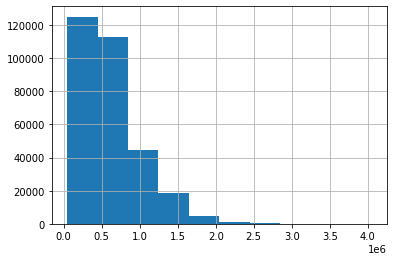

In [ ]:
app_train['AMT_CREDIT'].hist()
#plt.hist(app_train['AMT_INCOME_TOTAL'])

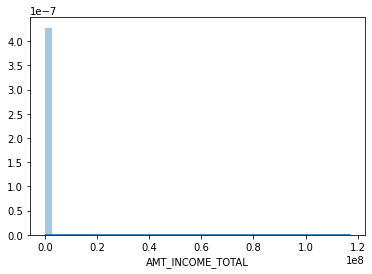

In [ ]:
sns.distplot(app_train['AMT_INCOME_TOTAL'])

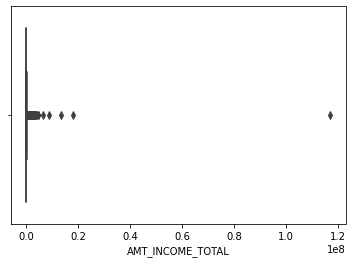

In [ ]:
sns.boxplot(app_train['AMT_INCOME_TOTAL'])

#### AMT_INCOME_TOTAL이 1000000 이하인 값에 대한 분포도 
* boolean indexing으로 filtering 후 histogram 표현

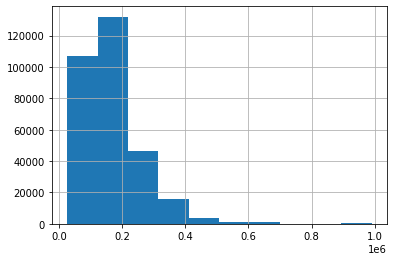

In [ ]:
# boolean indexing 으로 filtering 적용 
app_train[app_train['AMT_INCOME_TOTAL'] < 1000000]['AMT_INCOME_TOTAL'].hist()

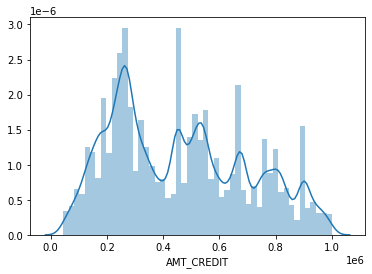

In [ ]:
# distplot으로 histogram 표현 
sns.distplot(app_train[app_train['AMT_CREDIT'] < 1000000]['AMT_CREDIT'])

#### TARGET 값에 따른 AMT_INCOME_TOTAL값 분포도 비교
* distplot과 violinplot 시각화
* plt.subplots() 기반으로 seaborn의 distplot과 violinplot으로 분포도 비교 시각화

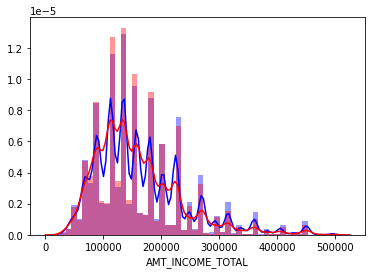

In [ ]:
# TARGET값에 따른 Filtering 조건 각각 설정. 
cond1 = (app_train['TARGET'] == 1)
cond0 = (app_train['TARGET'] == 0)
# AMT_INCOME_TOTAL은 매우 큰 값이 있으므로 이는 제외.
cond_amt = (app_train['AMT_INCOME_TOTAL'] < 500000)
# distplot으로 TARGET=1이면 빨간색으로, 0이면 푸른색으로 Histogram 표현 
sns.distplot(app_train[cond0 & cond_amt]['AMT_INCOME_TOTAL'], label='0', color='blue')
sns.distplot(app_train[cond1 & cond_amt]['AMT_INCOME_TOTAL'], label='1', color='red')

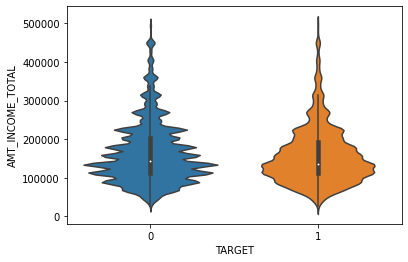

In [ ]:
# violinplot을 이용하면 Category 값별로 연속형 값의 분포도를 알수 있음. x는 category컬럼, y는 연속형 컬럼 
sns.violinplot(x='TARGET', y='AMT_INCOME_TOTAL', data=app_train[cond_amt])

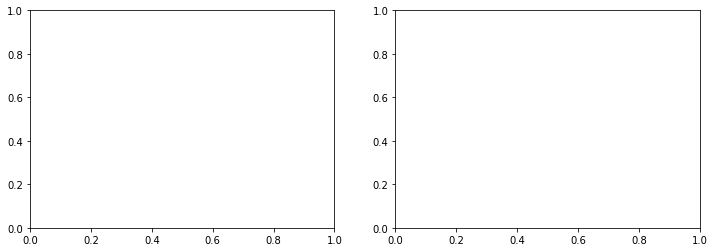

In [ ]:
# 2개의 subplot을 생성
fig, axs = plt.subplots(figsize=(12, 4), nrows=1, ncols=2)

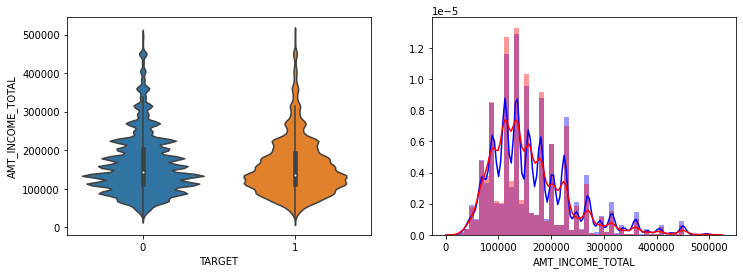

In [ ]:
# TARGET 값 유형에 따른 Boolean Indexing 조건
cond1 = (app_train['TARGET'] == 1)
cond0 = (app_train['TARGET'] == 0)
cond_amt = (app_train['AMT_INCOME_TOTAL'] < 500000)
# 2개의 subplot을 생성하고  왼쪽에는 violinplot을 오른쪽에는 distplot을 표현
fig, axs = plt.subplots(figsize=(12, 4), nrows=1, ncols=2, squeeze=False)
# violin plot을 왼쪽 subplot에 그림. 
sns.violinplot(x='TARGET', y='AMT_INCOME_TOTAL', data=app_train[cond_amt], ax=axs[0][0] )
# Histogram을 오른쪽 subplot에 그림. 
sns.distplot(app_train[cond0 & cond_amt]['AMT_INCOME_TOTAL'], ax=axs[0][1], label='0', color='blue')
sns.distplot(app_train[cond1 & cond_amt]['AMT_INCOME_TOTAL'], ax=axs[0][1], label='1', color='red')

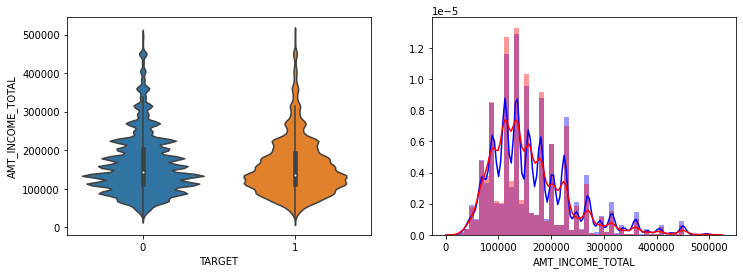

In [ ]:
def show_column_hist_by_target(df, column, is_amt=False):
    
    cond1 = (df['TARGET'] == 1)
    cond0 = (df['TARGET'] == 0)

    fig, axs = plt.subplots(figsize=(12, 4), nrows=1, ncols=2, squeeze=False)
    # is_amt가 True이면 < 500000 조건으로 filtering
    cond_amt = True
    if is_amt:
        cond_amt = df[column] < 500000
    
    sns.violinplot(x='TARGET', y=column, data=df[cond_amt], ax=axs[0][0] )
    sns.distplot(df[cond0 & cond_amt][column], ax=axs[0][1], label='0', color='blue')
    sns.distplot(df[cond1 & cond_amt][column], ax=axs[0][1], label='1', color='red')

show_column_hist_by_target(app_train, 'AMT_INCOME_TOTAL', is_amt=True)

#### app_train과 app_test를 합쳐서 한번에 데이터 preprocessing 수행. 

In [ ]:
app_train.shape, app_test.shape

((307511, 122), (48744, 121))

In [ ]:
# pandas의 concat()을 이용하여 app_train과 app_test를 결합
apps = pd.concat([app_train, app_test])
apps.shape

(356255, 122)

In [ ]:
# app_train의 TARGET 값을 Null로 입력됨. 
apps['TARGET'].value_counts(dropna=False)

0.0    282686
NaN     48744
1.0     24825
Name: TARGET, dtype: int64

#### Object feature들을 Label Encoding
* pandas의 factorize()를 이용

In [ ]:
apps.info()

In [ ]:
# pd.factorize()는 편리하게 Category 컬럼을 Label인코딩 수행. 
# pd.factorize(Category컬럼 Series)는 Label인코딩된 Series와 uniq한 Category값을 반환함. [0]을 이용하여 Label인코딩 Series만 취함. 
apps['CODE_GENDER'] = pd.factorize(apps['CODE_GENDER'])[0]

In [ ]:
# Label 인코딩을 위해 object 유형의 컬럼만 추출 
object_columns = apps.dtypes[apps.dtypes == 'object'].index.tolist()

In [ ]:
object_columns

['NAME_CONTRACT_TYPE',
 'FLAG_OWN_CAR',
 'FLAG_OWN_REALTY',
 'NAME_TYPE_SUITE',
 'NAME_INCOME_TYPE',
 'NAME_EDUCATION_TYPE',
 'NAME_FAMILY_STATUS',
 'NAME_HOUSING_TYPE',
 'OCCUPATION_TYPE',
 'WEEKDAY_APPR_PROCESS_START',
 'ORGANIZATION_TYPE',
 'FONDKAPREMONT_MODE',
 'HOUSETYPE_MODE',
 'WALLSMATERIAL_MODE',
 'EMERGENCYSTATE_MODE']

In [ ]:
# pd.factorize()는 한개의 컬럼만 Label 인코딩이 가능하므로 object형 컬럼들을 iteration하면서 변환 수행. 
for column in object_columns:
    apps[column] = pd.factorize(apps[column])[0]

In [ ]:
apps.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 356255 entries, 0 to 48743
Columns: 122 entries, SK_ID_CURR to AMT_REQ_CREDIT_BUREAU_YEAR
dtypes: float64(66), int64(56)
memory usage: 334.3 MB


#### Null값 일괄 변환

In [ ]:
apps.isnull().sum().head(100)

SK_ID_CURR                           0
TARGET                           48744
NAME_CONTRACT_TYPE                   0
CODE_GENDER                          0
FLAG_OWN_CAR                         0
FLAG_OWN_REALTY                      0
CNT_CHILDREN                         0
AMT_INCOME_TOTAL                     0
AMT_CREDIT                           0
AMT_ANNUITY                         36
AMT_GOODS_PRICE                    278
NAME_TYPE_SUITE                      0
NAME_INCOME_TYPE                     0
NAME_EDUCATION_TYPE                  0
NAME_FAMILY_STATUS                   0
NAME_HOUSING_TYPE                    0
REGION_POPULATION_RELATIVE           0
DAYS_BIRTH                           0
DAYS_EMPLOYED                        0
DAYS_REGISTRATION                    0
DAYS_ID_PUBLISH                      0
OWN_CAR_AGE                     235241
FLAG_MOBIL                           0
FLAG_EMP_PHONE                       0
FLAG_WORK_PHONE                      0
FLAG_CONT_MOBILE         

In [ ]:
# -999로 모든 컬럼들의 Null값 변환
apps = apps.fillna(-999)

In [ ]:
apps.isnull().sum().head(100)

SK_ID_CURR                      0
TARGET                          0
NAME_CONTRACT_TYPE              0
CODE_GENDER                     0
FLAG_OWN_CAR                    0
FLAG_OWN_REALTY                 0
CNT_CHILDREN                    0
AMT_INCOME_TOTAL                0
AMT_CREDIT                      0
AMT_ANNUITY                     0
AMT_GOODS_PRICE                 0
NAME_TYPE_SUITE                 0
NAME_INCOME_TYPE                0
NAME_EDUCATION_TYPE             0
NAME_FAMILY_STATUS              0
NAME_HOUSING_TYPE               0
REGION_POPULATION_RELATIVE      0
DAYS_BIRTH                      0
DAYS_EMPLOYED                   0
DAYS_REGISTRATION               0
DAYS_ID_PUBLISH                 0
OWN_CAR_AGE                     0
FLAG_MOBIL                      0
FLAG_EMP_PHONE                  0
FLAG_WORK_PHONE                 0
FLAG_CONT_MOBILE                0
FLAG_PHONE                      0
FLAG_EMAIL                      0
OCCUPATION_TYPE                 0
CNT_FAM_MEMBER

#### 학습 데이터와 테스트 데이터 다시 분리

In [ ]:
# app_test의 TARGET 컬럼은 원래 null이었는데 앞에서 fillna(-999)로 -999로 변환됨. 이를 추출함. 
app_train = apps[apps['TARGET'] != -999]
app_test = apps[apps['TARGET']== -999]
app_train.shape, app_test.shape

((307511, 122), (48744, 122))

In [ ]:
# app_test의 TARGET컬럼을 Drop
app_test = app_test.drop('TARGET', axis=1)

In [ ]:
app_test.shape

(48744, 121)

In [ ]:
app_test.dtypes

SK_ID_CURR                      int64
NAME_CONTRACT_TYPE              int64
CODE_GENDER                     int64
FLAG_OWN_CAR                    int64
FLAG_OWN_REALTY                 int64
                               ...   
AMT_REQ_CREDIT_BUREAU_DAY     float64
AMT_REQ_CREDIT_BUREAU_WEEK    float64
AMT_REQ_CREDIT_BUREAU_MON     float64
AMT_REQ_CREDIT_BUREAU_QRT     float64
AMT_REQ_CREDIT_BUREAU_YEAR    float64
Length: 121, dtype: object

#### 학습 데이터를 검증 데이터로 분리하고 LGBM Classifier로 학습 수행. 
* 피처용 데이터와 타겟 데이터 분리
* 학습용/검증용 데이터 세트 분리

In [ ]:
ftr_app = app_train.drop(['SK_ID_CURR', 'TARGET'], axis=1)
target_app = app_train['TARGET']

In [ ]:
from sklearn.model_selection import train_test_split

train_x, valid_x, train_y, valid_y = train_test_split(ftr_app, target_app, test_size=0.3, random_state=2020)
train_x.shape, valid_x.shape

((215257, 120), (92254, 120))

In [ ]:
from lightgbm import LGBMClassifier

clf = LGBMClassifier(
        n_jobs=-1,
        n_estimators=1000,
        learning_rate=0.02,
        num_leaves=32,
        subsample=0.8,
        max_depth=12,
        silent=-1,
        verbose=-1
        )

clf.fit(train_x, train_y, eval_set=[(train_x, train_y), (valid_x, valid_y)], 
eval_metric= 'auc', verbose= 100, early_stopping_rounds= 50)

Training until validation scores don't improve for 50 rounds.
[100]	training's binary_logloss: 0.250361	training's auc: 0.752239	valid_1's binary_logloss: 0.251609	valid_1's auc: 0.744198
[200]	training's binary_logloss: 0.243534	training's auc: 0.771653	valid_1's binary_logloss: 0.247513	valid_1's auc: 0.754199
[300]	training's binary_logloss: 0.239351	training's auc: 0.784972	valid_1's binary_logloss: 0.246218	valid_1's auc: 0.757636
[400]	training's binary_logloss: 0.235986	training's auc: 0.796437	valid_1's binary_logloss: 0.245638	valid_1's auc: 0.759327
[500]	training's binary_logloss: 0.233059	training's auc: 0.806414	valid_1's binary_logloss: 0.245448	valid_1's auc: 0.759816
[600]	training's binary_logloss: 0.23033	training's auc: 0.815154	valid_1's binary_logloss: 0.245364	valid_1's auc: 0.759934
Early stopping, best iteration is:
[569]	training's binary_logloss: 0.231137	training's auc: 0.81267	valid_1's binary_logloss: 0.245366	valid_1's auc: 0.759984


LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
               importance_type='split', learning_rate=0.02, max_depth=12,
               min_child_samples=20, min_child_weight=0.001, min_split_gain=0.0,
               n_estimators=1000, n_jobs=-1, num_leaves=32, objective=None,
               random_state=None, reg_alpha=0.0, reg_lambda=0.0, silent=-1,
               subsample=0.8, subsample_for_bin=200000, subsample_freq=0,
               verbose=-1)

##### Feature importance 시각화 

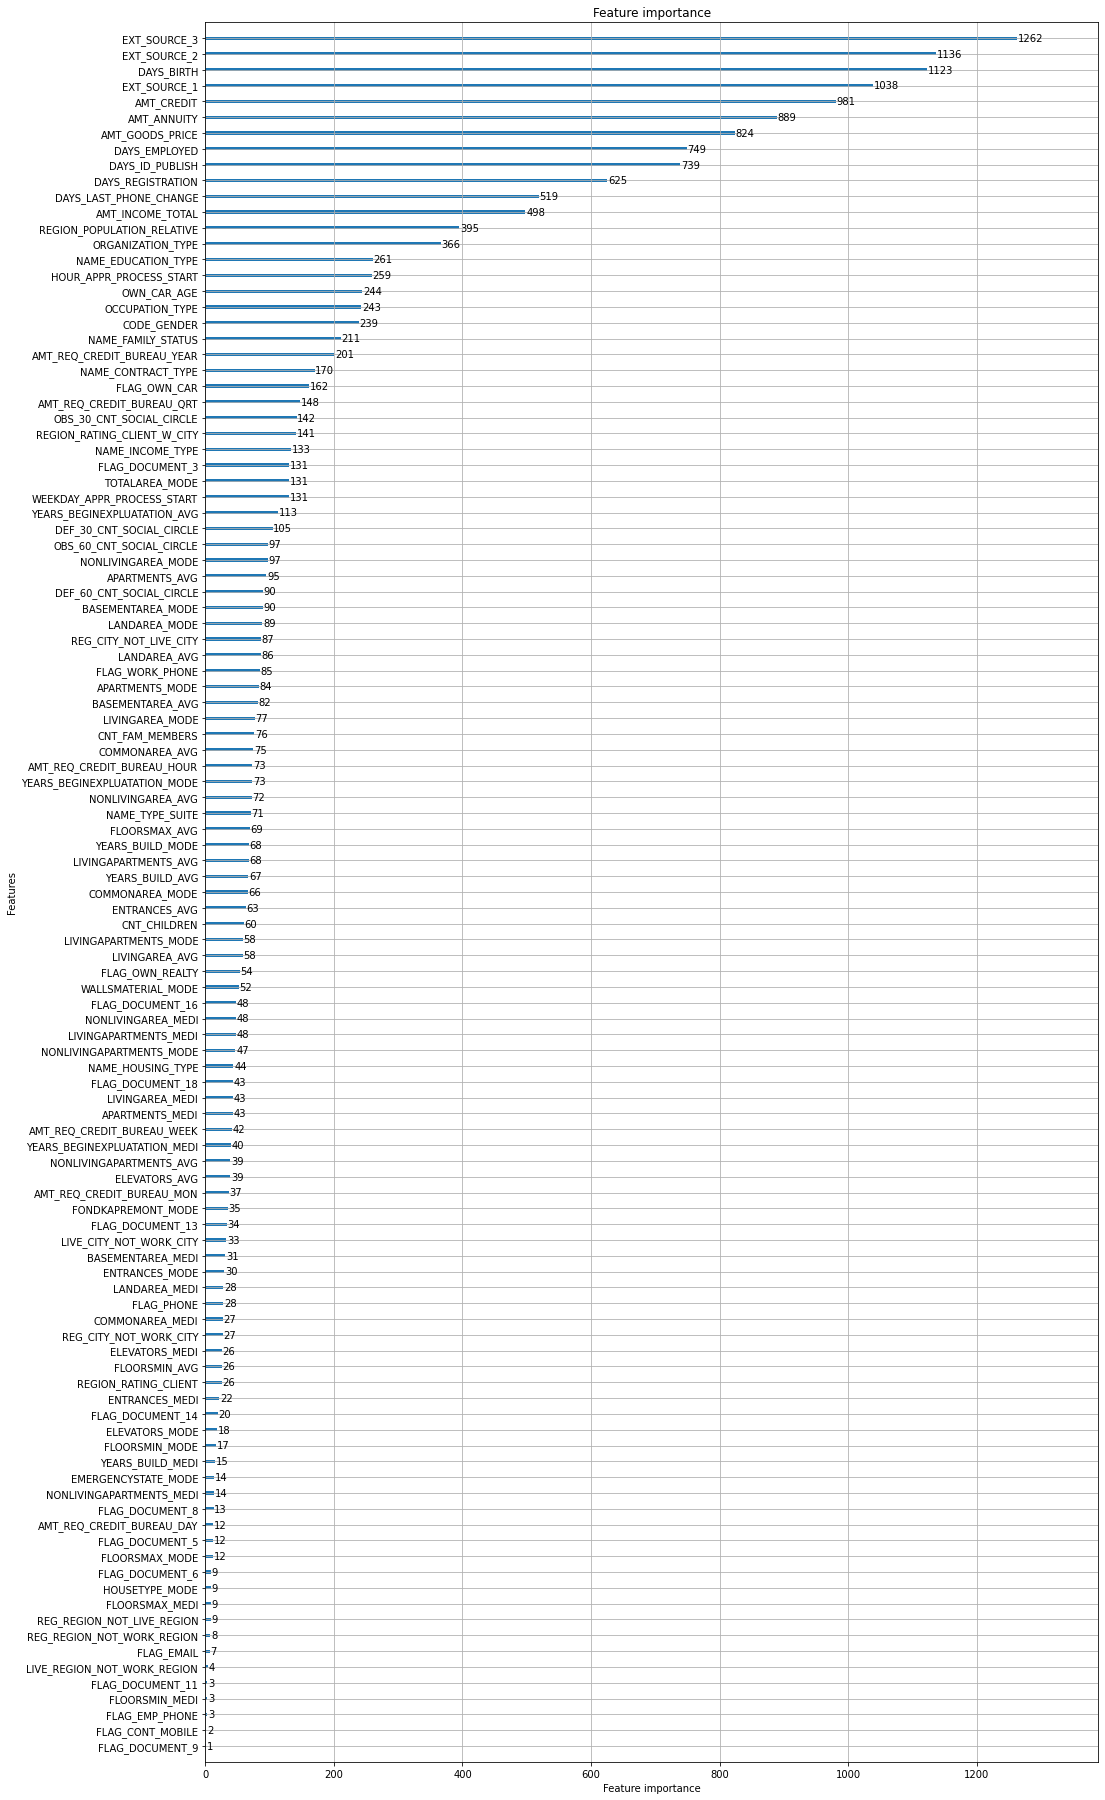

In [ ]:
from lightgbm import plot_importance

plot_importance(clf, figsize=(16, 32))

#### 학습된 Classifier를 이용하여 테스트 데이터을 예측하고 결과를 Kaggle로 Submit 수행. 

In [ ]:
#학습된 classifier의 predict_proba()를 이용하여 binary classification에서 1이될 확률만 추출
preds = clf.predict_proba(app_test.drop(['SK_ID_CURR'], axis=1))[:, 1 ]

In [ ]:
# app_test의 TARGET으로 1이될 확률 Update
app_test['TARGET'] = preds
app_test['TARGET'].head(10)

0    0.029664
1    0.114657
2    0.016018
3    0.044586
4    0.148616
5    0.035927
6    0.017008
7    0.041639
8    0.017502
9    0.086631
Name: TARGET, dtype: float64

##### 코랩 버전은 Google Drive로 예측 결과 CSV를 생성.

In [ ]:
import os, sys 
from google.colab import drive 

drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [ ]:
# SK_ID_CURR과 TARGET 값만 csv 형태로 생성. 코랩 버전은 구글 드라이브 절대 경로로 입력  
default_dir = "/content/gdrive/My Drive"
app_test[['SK_ID_CURR', 'TARGET']].to_csv(os.path.join(default_dir, 'app_baseline_01.csv'), index=False)

In [ ]:
!ls "/content/gdrive/My Drive"

 app_baseline_01.csv	'Colab Notebooks'	        test01.ipynb
 application_test.csv	 John_Wick_small_tensor01.avi   Untitled0.ipynb
 application_train.csv	 NFL_yolo_01.avi
 bkup			 test001.ipynb
